In [180]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [181]:
# Importing and inspecting CD file
df = pd.read_csv("data/aerodynamic_data_set_with_labels.csv")

df

,rle,xup,yup,yxxup,xlo,ylo,yxxlo,alpha_te,beta_te,CL,CD,CM
0,0.007840,0.433200,0.062900,-0.424500,0.361800,-0.058900,0.706900,-0.112600,0.164600,0.808246,0.007262,0.121544
1,0.008520,0.389880,0.069190,-0.466950,0.397980,-0.064790,0.777590,-0.123860,0.148140,0.800081,0.018035,0.126753
2,0.007160,0.476520,0.056610,-0.382050,0.325620,-0.053010,0.636210,-0.101340,0.181060,0.779725,0.003612,0.110895
3,0.007500,0.411540,0.066045,-0.488175,0.416070,-0.050065,0.600865,-0.106970,0.139910,0.796090,0.012809,0.118196
4,0.008860,0.498180,0.053465,-0.403275,0.343710,-0.061845,0.742245,-0.129490,0.172830,0.764920,0.007443,0.107714
...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.006655,0.422708,0.059018,-0.416872,0.348515,-0.054436,0.612463,-0.095622,0.174245,0.733211,0.004544,0.099914
496,0.008015,0.509348,0.071598,-0.501772,0.420875,-0.066216,0.753843,-0.118142,0.141325,0.828059,0.009883,0.142013
497,0.008695,0.379388,0.065308,-0.374422,0.384695,-0.048546,0.824533,-0.106882,0.190705,0.911397,0.018699,0.146730
498,0.007335,0.466028,0.052728,-0.459322,0.312335,-0.060326,0.683153,-0.129402,0.157785,0.711286,0.005625,0.098725


In [182]:
# # Plot correlation heatmap
# plt.figure(figsize=(20, 5))

# # print(df.corr(method="pearson").to_latex)
# sns.heatmap(df.corr(method="pearson"), annot=True, vmin=-1, vmax=1, fmt=".6f")

# # Change the y-axis rotation
# plt.yticks(rotation=0)

# # Place x-axis on top
# plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

# # Change the x-tick values
# plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)

# # CHange the y-tick values
# plt.yticks(np.arange(0.5, len(df.columns), 1), df.columns)

# # Export to svg & png
# plt.savefig("./laporan/graph/case2_corr_heatmap.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
# plt.savefig("./laporan/graph/case2_corr_heatmap.png", format = 'png', dpi=300, bbox_inches = 'tight')

# # Show the plot
# plt.show()

In [183]:
# # Use PairGrid to visualize each column relation with others
# g = sns.PairGrid(df)
# g.map_diag(sns.histplot, kde=True)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()

# plt.savefig("./laporan/graph/case2_data_dist.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
# plt.savefig("./laporan/graph/case2_data_dist.png", format = 'png', dpi=300, bbox_inches = 'tight')

In [184]:
#Separating variables and response
x = df.drop(['CL', 'CD', 'CM'], axis=1)
y = df[['CL', 'CD', 'CM']]

In [185]:
# Normalizing inputs
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)

In [186]:
# Creating train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.2, random_state=1)

In [187]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy as sp

# Create a class to for linear regression
class LinearRegression(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate number of data points
        self.training_n_ = X.shape[0]

        # Calculate number of variables
        self.p_ = X.shape[1]

        # Compute F by concaneating a column of ones to X
        F = np.c_[np.ones(self.training_n_), X]

        # Compute the estimation of coefficients
        self.beta_ = np.linalg.inv(F.T @ F) @ F.T @ y

        # Compute the RSS of beta
        self.RSS_ = np.sum((y - F @ self.beta_)**2)

        # Compute the RSE of beta
        self.RSE_ = np.sqrt(self.RSS_ / (self.training_n_ - self.p_ - 1))

        # Compute the estimation of variance of the model
        self.var_ = self.RSS_ / (self.training_n_ - self.p_ - 1)

        # Compute the estimation of variance of the coefficients
        self.beta_var_ = (self.var_ * np.linalg.inv(F.T @ F)).diagonal()
    
    def predict(self, X):
        # Calculate number of data points
        n = X.shape[0]

        # Compute F
        F = np.c_[np.ones(n), X]

        # Compute the prediction
        y_pred = F @ self.beta_

        return y_pred
    
    def evaluation_report(self, alpha=0.05):
        # Calculate standard error
        beta_se_ = np.sqrt(self.beta_var_)

        # Calculate t-statistic
        t_stat_ = self.beta_ / beta_se_

        # Calculate degree of freedom
        df_ = self.training_n_ - self.p_

        # Calculate p-value
        p_value_ = sp.stats.t.sf(np.abs(t_stat_), df_) * 2

        # Determine hypothesis test result
        hypothesis_test_result_ = np.where(p_value_ < alpha, 'Reject H0', 'Do Not Reject H0')

        # Create a dataframe to store the result
        result = pd.DataFrame({
            "Beta": self.beta_,
            "Standard Error": beta_se_,
            "t-statistic": t_stat_,
            "p-value": p_value_,
            "Hypothesis Test Result": hypothesis_test_result_
        })

        return result

In [188]:
model = LinearRegression()

In [189]:
# fitting the model
model.fit(x_train,y_train["CD"])

In [190]:
# making y_pred_CD
y_pred_CD = model.predict(x_test)

In [191]:
# Model Evaluation
print("RMSE: ", np.sqrt(mean_squared_error(y_test["CD"], y_pred_CD)))
print("MAE: ", mean_absolute_error(y_test["CD"], y_pred_CD))

RMSE:  0.0031203994798080052
MAE:  0.002393460092364095


In [192]:
model.RSE_

0.003313589571430225

In [193]:
model.evaluation_report()

,Beta,Standard Error,t-statistic,p-value,Hypothesis Test Result
0,0.003348,0.000917,3.650961,2.967747e-04,Reject H0
1,-0.000122,0.000574,-0.212497,8.318299e-01,Do Not Reject H0
2,-0.008557,0.000575,-14.881558,5.263659e-40,Reject H0
3,0.019872,0.000572,34.719043,1.666999e-121,Reject H0
4,-0.000251,0.000570,-0.440322,6.599476e-01,Do Not Reject H0
5,-0.001914,0.000577,-3.315638,9.998077e-04,Reject H0
6,0.006563,0.000580,11.320195,6.876674e-26,Reject H0
7,0.002742,0.000570,4.809075,2.167568e-06,Reject H0
8,-0.003241,0.000570,-5.684308,2.572116e-08,Reject H0
9,0.000050,0.000568,0.088217,9.297497e-01,Do Not Reject H0


In [194]:
# Import r2 score
from sklearn.metrics import r2_score

r_squared = r2_score(y_train["CD"], model.predict(x_train))
print("R-squared value: ", r_squared)

R-squared value:  0.8086169517569576


In [195]:
x.columns

Index(['rle', 'xup', 'yup', 'yxxup', 'xlo', 'ylo', 'yxxlo', 'alpha_te',
       'beta_te'],
      dtype='object')

In [196]:
model.beta_[1:]

array([-1.22029640e-04, -8.55693986e-03,  1.98719846e-02, -2.51177625e-04,
       -1.91403071e-03,  6.56297144e-03,  2.74216643e-03, -3.24083919e-03,
        5.00743316e-05])

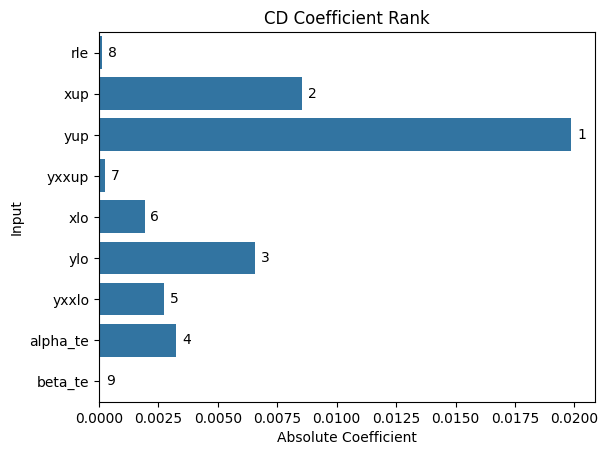

In [197]:
# Visualizing importance level through absolute value of beta
koefisien = pd.DataFrame({"Nama Kolom": x.columns, "Beta": abs(model.beta_[1:])})

# Add column representin the order of the coefficient
koefisien["Order"] = koefisien["Beta"].abs().rank(ascending=False)

ax = sns.barplot(x="Beta", y="Nama Kolom", data=koefisien, orient="h", color="tab:blue")

show = koefisien["Order"]
i = 0

for p in ax.patches:
    h = p.get_height()
    if (h > 0):
        value = show[i]
        ax.text(p.get_width() + 0.00025, p.get_y() + h / 2, str(int(value)), ha="left", va="center")
        i = i + 1

plt.xlabel("Absolute Coefficient")
plt.ylabel("Input")

plt.title("CD Coefficient Rank")

# Make the "Order" column shows at top of the bar
# plt.bar_label(barh)

plt.savefig("./laporan/graph/case2_cd_coef_rank.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case2_cd_coef_rank.png", format = 'png', dpi=300, bbox_inches = 'tight')

In [198]:
# Compute RMSE and MAE


In [199]:
# Hyperparameter with GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Create the model
knn = KNeighborsRegressor()

# Create the parameter grid
param_grid = {
    'n_neighbors': [k for k in range(1, 21)]
}

# Create the grid search
grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Scale the data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Fit the grid search
grid.fit(x_train_scaled, y_train["CD"])

# Print the best parameters
print("Best Parameters:")
print(f"{grid.best_params_}")

Best Parameters:
{'n_neighbors': 5}


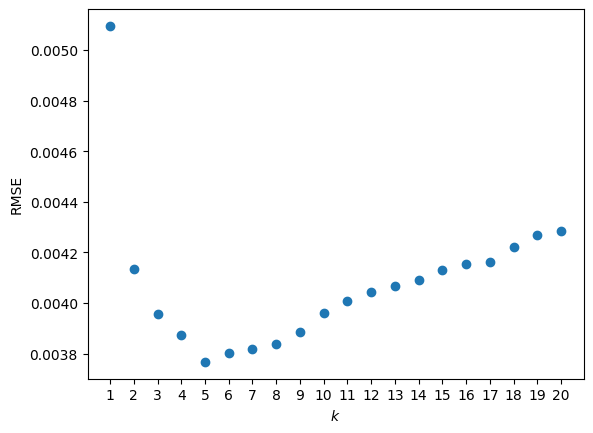

In [200]:
grid_cv_result = pd.DataFrame(grid.cv_results_)

plt.scatter(grid_cv_result['param_n_neighbors'], -grid_cv_result['mean_test_score'])

# Set tick to have increment of 1
plt.xticks(np.arange(1, 21, 1))

# Set the label
plt.xlabel('$k$')
plt.ylabel('RMSE')

# Export to png and svg
plt.savefig("./laporan/graph/case2_knnr_rmse_cd.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case2_knnr_rmse_cd.png", format = 'png', dpi=300, bbox_inches = 'tight')

In [201]:
# Create the model
knn = KNeighborsRegressor(**grid.best_params_)

# Fit the model
knn.fit(x_train_scaled, y_train["CD"])

# Scale the test set
x_test_scaled = scaler.transform(x_test)

# Predict the test set
y_pred_knn_CD = knn.predict(x_test_scaled)

In [203]:
# Model Evaluation
print("RMSE: ", mean_squared_error(y_test["CD"], y_pred_knn_CD, squared=False))
print("MAE: ", mean_absolute_error(y_test["CD"], y_pred_knn_CD))

RMSE:  0.003514155692684591
MAE:  0.0026759509720000003
